In [25]:
from robustbench.data import load_cifar10
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torchattacks
import os

In [26]:
# Simple CNN Model
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        # First conv block
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)  # 32x32 -> 16x16
        
        # Second conv block
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)  # 16x16 -> 8x8
        
        # Third conv block
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)  # 8x8 -> 4x4
        
        # Fully connected layers
        self.fc1 = nn.Linear(256 * 4 * 4, 512 )
        self.fc2 = nn.Linear(512, num_classes)
        
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    
    def forward(self, x, return_layer0=False, training=False):
        # First conv block
        x = self.conv1(x)
        layer0 = x.clone()
        x = self.tanh(x)
        x = self.relu(self.conv2(x))
        x = self.pool1(x)
        
        # Second conv block
        x = self.tanh(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.pool2(x)
        
        # Third conv block
        x = self.relu(self.conv5(x))
        x = self.pool3(x)
        
        # Flatten and fully connected
        x = x.view(x.size(0), -1)
        
        x = self.relu(self.fc1(x))
        x = self.fc2(x)

        if return_layer0:
            return x, layer0
        return x

# Data loading and preprocessing
def load_cifar10():
    # Simple data augmentation for training
    train_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
    ])
    
    # No augmentation for test
    test_transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    
    # Load datasets
    trainset = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True, transform=train_transform
    )
    trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=128, shuffle=True, num_workers=2
    )
    
    testset = torchvision.datasets.CIFAR10(
        root='./data', train=False, download=True, transform=test_transform
    )
    testloader = torch.utils.data.DataLoader(
        testset, batch_size=128, shuffle=False, num_workers=2
    )
    return trainloader, testloader

In [27]:
trainloader, testloader = load_cifar10()

In [28]:
model = SimpleCNN(num_classes=10)
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

Model parameters: 2,638,794


In [29]:
torch.softmax(torch.tensor([1,0,0.0]), dim = 0)

tensor([0.5761, 0.2119, 0.2119])

In [30]:
torch.softmax(torch.tensor([1,0,0.0]) / 10, dim = 0)

tensor([0.3559, 0.3220, 0.3220])

In [31]:
def smooth_labels(targets, num_classes=10, temp=7, device='mps'):
    batch_size = targets.size(0)
    
    # Create one-hot encoding (δ_{k,y})
    one_hot = torch.zeros(batch_size, num_classes).to(device)
    one_hot.scatter_(1, targets.unsqueeze(1), 1)
    
    # print(one_hot)

    one_hot = one_hot / temp
    return torch.softmax(one_hot, dim=-1)
    

In [32]:
# smooth_labels(torch.tensor([1,2]).to('mps'))

In [33]:
# Training function
def train_model(model, trainloader, num_epochs=10):
    device = 'mps'
    model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    train_losses = []
    train_accuracies = []
    
    print(f"Training on {device}")
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for batch_idx, (inputs, targets) in enumerate(trainloader):
            inputs, targets = inputs.to(device), targets.to(device)
            # labels_smoothed = smooth_labels(targets, 10).to(device)
            optimizer.zero_grad()

            out, layer0 = model(inputs, return_layer0=True)

            # print(out.shape, targets.shape)
            # layer0_loss = torch.mean(nn.functional.relu(5 - torch.abs(layer0)))**2
            # print(layer0_loss)
            # print(nn.functional.relu(5 - torch.abs(layer0)) / layer0.numel())

            loss = criterion(out, targets) #+ (1/10) * layer0_loss
            loss.backward()
            optimizer.step()

            if batch_idx % 10 != 0:
                running_loss += loss.item()
                _, predicted = out.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
            
            if batch_idx % 100 == 99:
                print(f'Epoch: {epoch+1}/{num_epochs}, Batch: {batch_idx}, '
                      f'Loss: {loss.item():.4f}, Acc: {100.*correct/total:.2f}%')
        
        epoch_loss = running_loss / len(trainloader)
        epoch_acc = 100. * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        print(f'Epoch {epoch+1} completed: Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')
    
    return train_losses, train_accuracies

# Evaluation function
def evaluate_model(model, testloader):
    device = 'mps'
    model.eval()
    
    correct = 0
    total = 0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    
    classes = ('plane', 'car', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck')
    
    with torch.no_grad():
        for inputs, targets in testloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            
            # Per-class accuracy
            c = (predicted == targets).squeeze()
            for i in range(targets.size(0)):
                label = targets[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
    
    overall_acc = 100 * correct / total
    print(f'\nOverall Test Accuracy: {overall_acc:.2f}%')
    
    print('\nPer-class accuracies:')
    for i in range(10):
        if class_total[i] > 0:
            acc = 100 * class_correct[i] / class_total[i]
            print(f'{classes[i]}: {acc:.2f}%')
    
    return overall_acc

In [34]:
# Train model
print("\nStarting training...")
train_losses, train_accuracies = train_model(model, trainloader, num_epochs=50)


Starting training...
Training on mps


python(73687) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(73689) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch: 1/50, Batch: 99, Loss: 1.7273, Acc: 23.51%
Epoch: 1/50, Batch: 199, Loss: 1.6074, Acc: 29.17%
Epoch: 1/50, Batch: 299, Loss: 1.5440, Acc: 33.42%
Epoch 1 completed: Loss: 1.5274, Accuracy: 36.64%


python(73730) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(73731) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch: 2/50, Batch: 99, Loss: 1.2941, Acc: 52.13%
Epoch: 2/50, Batch: 199, Loss: 1.3992, Acc: 53.57%
Epoch: 2/50, Batch: 299, Loss: 1.0955, Acc: 55.30%
Epoch 2 completed: Loss: 1.0843, Accuracy: 56.71%


python(73760) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(73778) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch: 3/50, Batch: 99, Loss: 0.9805, Acc: 63.77%
Epoch: 3/50, Batch: 199, Loss: 0.9755, Acc: 64.47%
Epoch: 3/50, Batch: 299, Loss: 0.8768, Acc: 65.32%
Epoch 3 completed: Loss: 0.8581, Accuracy: 66.23%


python(73798) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(73799) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch: 4/50, Batch: 99, Loss: 0.8623, Acc: 70.55%
Epoch: 4/50, Batch: 199, Loss: 0.9999, Acc: 70.95%
Epoch: 4/50, Batch: 299, Loss: 0.7932, Acc: 71.40%
Epoch 4 completed: Loss: 0.7185, Accuracy: 71.83%


python(73851) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(73852) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch: 5/50, Batch: 99, Loss: 0.6177, Acc: 75.28%
Epoch: 5/50, Batch: 199, Loss: 0.6915, Acc: 75.14%
Epoch: 5/50, Batch: 299, Loss: 0.6819, Acc: 75.11%
Epoch 5 completed: Loss: 0.6378, Accuracy: 75.18%


python(73882) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(73885) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch: 6/50, Batch: 99, Loss: 0.5223, Acc: 77.25%
Epoch: 6/50, Batch: 199, Loss: 0.6527, Acc: 77.38%
Epoch: 6/50, Batch: 299, Loss: 0.7048, Acc: 77.25%
Epoch 6 completed: Loss: 0.5845, Accuracy: 77.27%


python(73923) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(73924) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch: 7/50, Batch: 99, Loss: 0.6689, Acc: 78.85%
Epoch: 7/50, Batch: 199, Loss: 0.6434, Acc: 78.75%
Epoch: 7/50, Batch: 299, Loss: 0.5561, Acc: 78.79%
Epoch 7 completed: Loss: 0.5444, Accuracy: 78.90%


python(73956) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(73957) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch: 8/50, Batch: 99, Loss: 0.5003, Acc: 80.10%
Epoch: 8/50, Batch: 199, Loss: 0.4166, Acc: 80.00%
Epoch: 8/50, Batch: 299, Loss: 0.6700, Acc: 80.08%
Epoch 8 completed: Loss: 0.5139, Accuracy: 79.99%


python(74012) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(74014) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch: 9/50, Batch: 99, Loss: 0.3537, Acc: 81.75%
Epoch: 9/50, Batch: 199, Loss: 0.5154, Acc: 81.53%
Epoch: 9/50, Batch: 299, Loss: 0.6036, Acc: 81.58%
Epoch 9 completed: Loss: 0.4768, Accuracy: 81.49%


python(74054) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(74055) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch: 10/50, Batch: 99, Loss: 0.5158, Acc: 82.37%
Epoch: 10/50, Batch: 199, Loss: 0.5904, Acc: 82.57%
Epoch: 10/50, Batch: 299, Loss: 0.5759, Acc: 82.40%
Epoch 10 completed: Loss: 0.4542, Accuracy: 82.30%


python(74071) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(74072) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch: 11/50, Batch: 99, Loss: 0.4758, Acc: 82.88%
Epoch: 11/50, Batch: 199, Loss: 0.4623, Acc: 83.10%
Epoch: 11/50, Batch: 299, Loss: 0.6856, Acc: 82.90%
Epoch 11 completed: Loss: 0.4411, Accuracy: 82.82%


python(74116) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(74126) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch: 12/50, Batch: 99, Loss: 0.5530, Acc: 84.20%
Epoch: 12/50, Batch: 199, Loss: 0.4137, Acc: 83.77%
Epoch: 12/50, Batch: 299, Loss: 0.3220, Acc: 83.98%
Epoch 12 completed: Loss: 0.4110, Accuracy: 84.05%


python(74163) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(74164) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch: 13/50, Batch: 99, Loss: 0.5014, Acc: 84.91%
Epoch: 13/50, Batch: 199, Loss: 0.3263, Acc: 84.69%
Epoch: 13/50, Batch: 299, Loss: 0.4430, Acc: 84.77%
Epoch 13 completed: Loss: 0.3988, Accuracy: 84.53%


python(74241) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(74242) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch: 14/50, Batch: 99, Loss: 0.5951, Acc: 85.25%
Epoch: 14/50, Batch: 199, Loss: 0.4236, Acc: 85.42%
Epoch: 14/50, Batch: 299, Loss: 0.5858, Acc: 85.34%
Epoch 14 completed: Loss: 0.3783, Accuracy: 85.31%


python(74261) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(74267) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch: 15/50, Batch: 99, Loss: 0.4660, Acc: 86.02%
Epoch: 15/50, Batch: 199, Loss: 0.4257, Acc: 85.61%
Epoch: 15/50, Batch: 299, Loss: 0.3707, Acc: 85.58%
Epoch 15 completed: Loss: 0.3688, Accuracy: 85.64%


python(74295) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(74297) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch: 16/50, Batch: 99, Loss: 0.3892, Acc: 87.02%
Epoch: 16/50, Batch: 199, Loss: 0.3809, Acc: 86.51%
Epoch: 16/50, Batch: 299, Loss: 0.4807, Acc: 86.14%
Epoch 16 completed: Loss: 0.3613, Accuracy: 86.03%


python(74365) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(74366) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch: 17/50, Batch: 99, Loss: 0.4752, Acc: 86.92%
Epoch: 17/50, Batch: 199, Loss: 0.5646, Acc: 86.52%
Epoch: 17/50, Batch: 299, Loss: 0.3080, Acc: 86.47%
Epoch 17 completed: Loss: 0.3488, Accuracy: 86.48%


python(74391) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(74392) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch: 18/50, Batch: 99, Loss: 0.3867, Acc: 87.89%
Epoch: 18/50, Batch: 199, Loss: 0.2805, Acc: 87.59%
Epoch: 18/50, Batch: 299, Loss: 0.4903, Acc: 87.51%
Epoch 18 completed: Loss: 0.3271, Accuracy: 87.30%


python(74421) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(74422) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch: 19/50, Batch: 99, Loss: 0.3092, Acc: 87.96%
Epoch: 19/50, Batch: 199, Loss: 0.5035, Acc: 87.63%
Epoch: 19/50, Batch: 299, Loss: 0.2962, Acc: 87.38%
Epoch 19 completed: Loss: 0.3297, Accuracy: 87.18%


python(74452) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(74453) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch: 20/50, Batch: 99, Loss: 0.2498, Acc: 87.39%
Epoch: 20/50, Batch: 199, Loss: 0.2590, Acc: 87.43%
Epoch: 20/50, Batch: 299, Loss: 0.3826, Acc: 87.40%
Epoch 20 completed: Loss: 0.3185, Accuracy: 87.54%


python(74495) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(74496) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch: 21/50, Batch: 99, Loss: 0.3438, Acc: 87.99%
Epoch: 21/50, Batch: 199, Loss: 0.2673, Acc: 88.24%
Epoch: 21/50, Batch: 299, Loss: 0.4472, Acc: 88.30%
Epoch 21 completed: Loss: 0.3066, Accuracy: 88.13%


python(74535) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(74538) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch: 22/50, Batch: 99, Loss: 0.3491, Acc: 89.03%
Epoch: 22/50, Batch: 199, Loss: 0.3755, Acc: 88.76%
Epoch: 22/50, Batch: 299, Loss: 0.4948, Acc: 88.42%
Epoch 22 completed: Loss: 0.2994, Accuracy: 88.39%


python(74578) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(74580) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch: 23/50, Batch: 99, Loss: 0.2280, Acc: 89.25%
Epoch: 23/50, Batch: 199, Loss: 0.4055, Acc: 88.99%
Epoch: 23/50, Batch: 299, Loss: 0.3829, Acc: 88.99%
Epoch 23 completed: Loss: 0.2881, Accuracy: 88.84%


python(74625) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(74626) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch: 24/50, Batch: 99, Loss: 0.3506, Acc: 89.32%
Epoch: 24/50, Batch: 199, Loss: 0.3211, Acc: 89.23%
Epoch: 24/50, Batch: 299, Loss: 0.3927, Acc: 89.12%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x117d50720>
Traceback (most recent call last):
  File "/Users/zephaniahroe/anaconda3/envs/robustbench-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/Users/zephaniahroe/anaconda3/envs/robustbench-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1627, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/Users/zephaniahroe/anaconda3/envs/robustbench-env/lib/python3.11/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/zephaniahroe/anaconda3/envs/robustbench-env/lib/python3.11/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/zephaniahroe/anaconda3/envs/robustbench-env/lib/python3.11/multiprocessing/connection

KeyboardInterrupt: 

In [ ]:
# Train model
print("\nStarting training...")
train_losses, train_accuracies = train_model(model, trainloader, num_epochs=100)


Starting training...
Training on mps
Epoch: 1/100, Batch: 99, Loss: 15.6957, Acc: 15.36%
Epoch: 1/100, Batch: 199, Loss: 9.7729, Acc: 15.92%
Epoch: 1/100, Batch: 299, Loss: 6.5714, Acc: 16.87%
Epoch 1 completed: Loss: 10.6122, Accuracy: 16.41%
Epoch: 2/100, Batch: 99, Loss: 4.3235, Acc: 17.00%
Epoch: 2/100, Batch: 199, Loss: 4.0015, Acc: 16.11%
Epoch: 2/100, Batch: 299, Loss: 3.8105, Acc: 16.09%
Epoch 2 completed: Loss: 3.8784, Accuracy: 16.13%
Epoch: 3/100, Batch: 99, Loss: 3.6934, Acc: 17.40%
Epoch: 3/100, Batch: 199, Loss: 3.3642, Acc: 15.38%
Epoch: 3/100, Batch: 299, Loss: 3.2343, Acc: 14.62%
Epoch 3 completed: Loss: 3.0709, Accuracy: 14.46%
Epoch: 4/100, Batch: 99, Loss: 3.1067, Acc: 14.58%
Epoch: 4/100, Batch: 199, Loss: 3.1135, Acc: 15.07%
Epoch: 4/100, Batch: 299, Loss: 3.0767, Acc: 14.56%
Epoch 4 completed: Loss: 2.7648, Accuracy: 14.29%
Epoch: 5/100, Batch: 99, Loss: 3.0572, Acc: 11.79%
Epoch: 5/100, Batch: 199, Loss: 2.8787, Acc: 11.79%
Epoch: 5/100, Batch: 299, Loss: 2.828

python(60715) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(60716) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch: 6/100, Batch: 99, Loss: 2.7410, Acc: 12.38%
Epoch: 6/100, Batch: 199, Loss: 2.7403, Acc: 11.98%
Epoch: 6/100, Batch: 299, Loss: 2.7718, Acc: 11.80%
Epoch 6 completed: Loss: 2.4976, Accuracy: 11.78%


python(60725) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(60726) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch: 7/100, Batch: 99, Loss: 2.7609, Acc: 11.41%
Epoch: 7/100, Batch: 199, Loss: 2.6555, Acc: 11.37%


In [35]:
filepath='two_tahn_model.pth'

os.makedirs(os.path.dirname(filepath) if os.path.dirname(filepath) else '.', exist_ok=True)
torch.save(model.state_dict(), filepath)

print(f"Model saved to {filepath}")

Model saved to two_tahn_model.pth


# Time for some wiggles

In [82]:
def wiggly_tanh(x):
    return nn.functional.tanh(x) + 0.02*torch.sin(100000 * x)

In [83]:
x = torch.arange(-5, 5.001, 0.001)

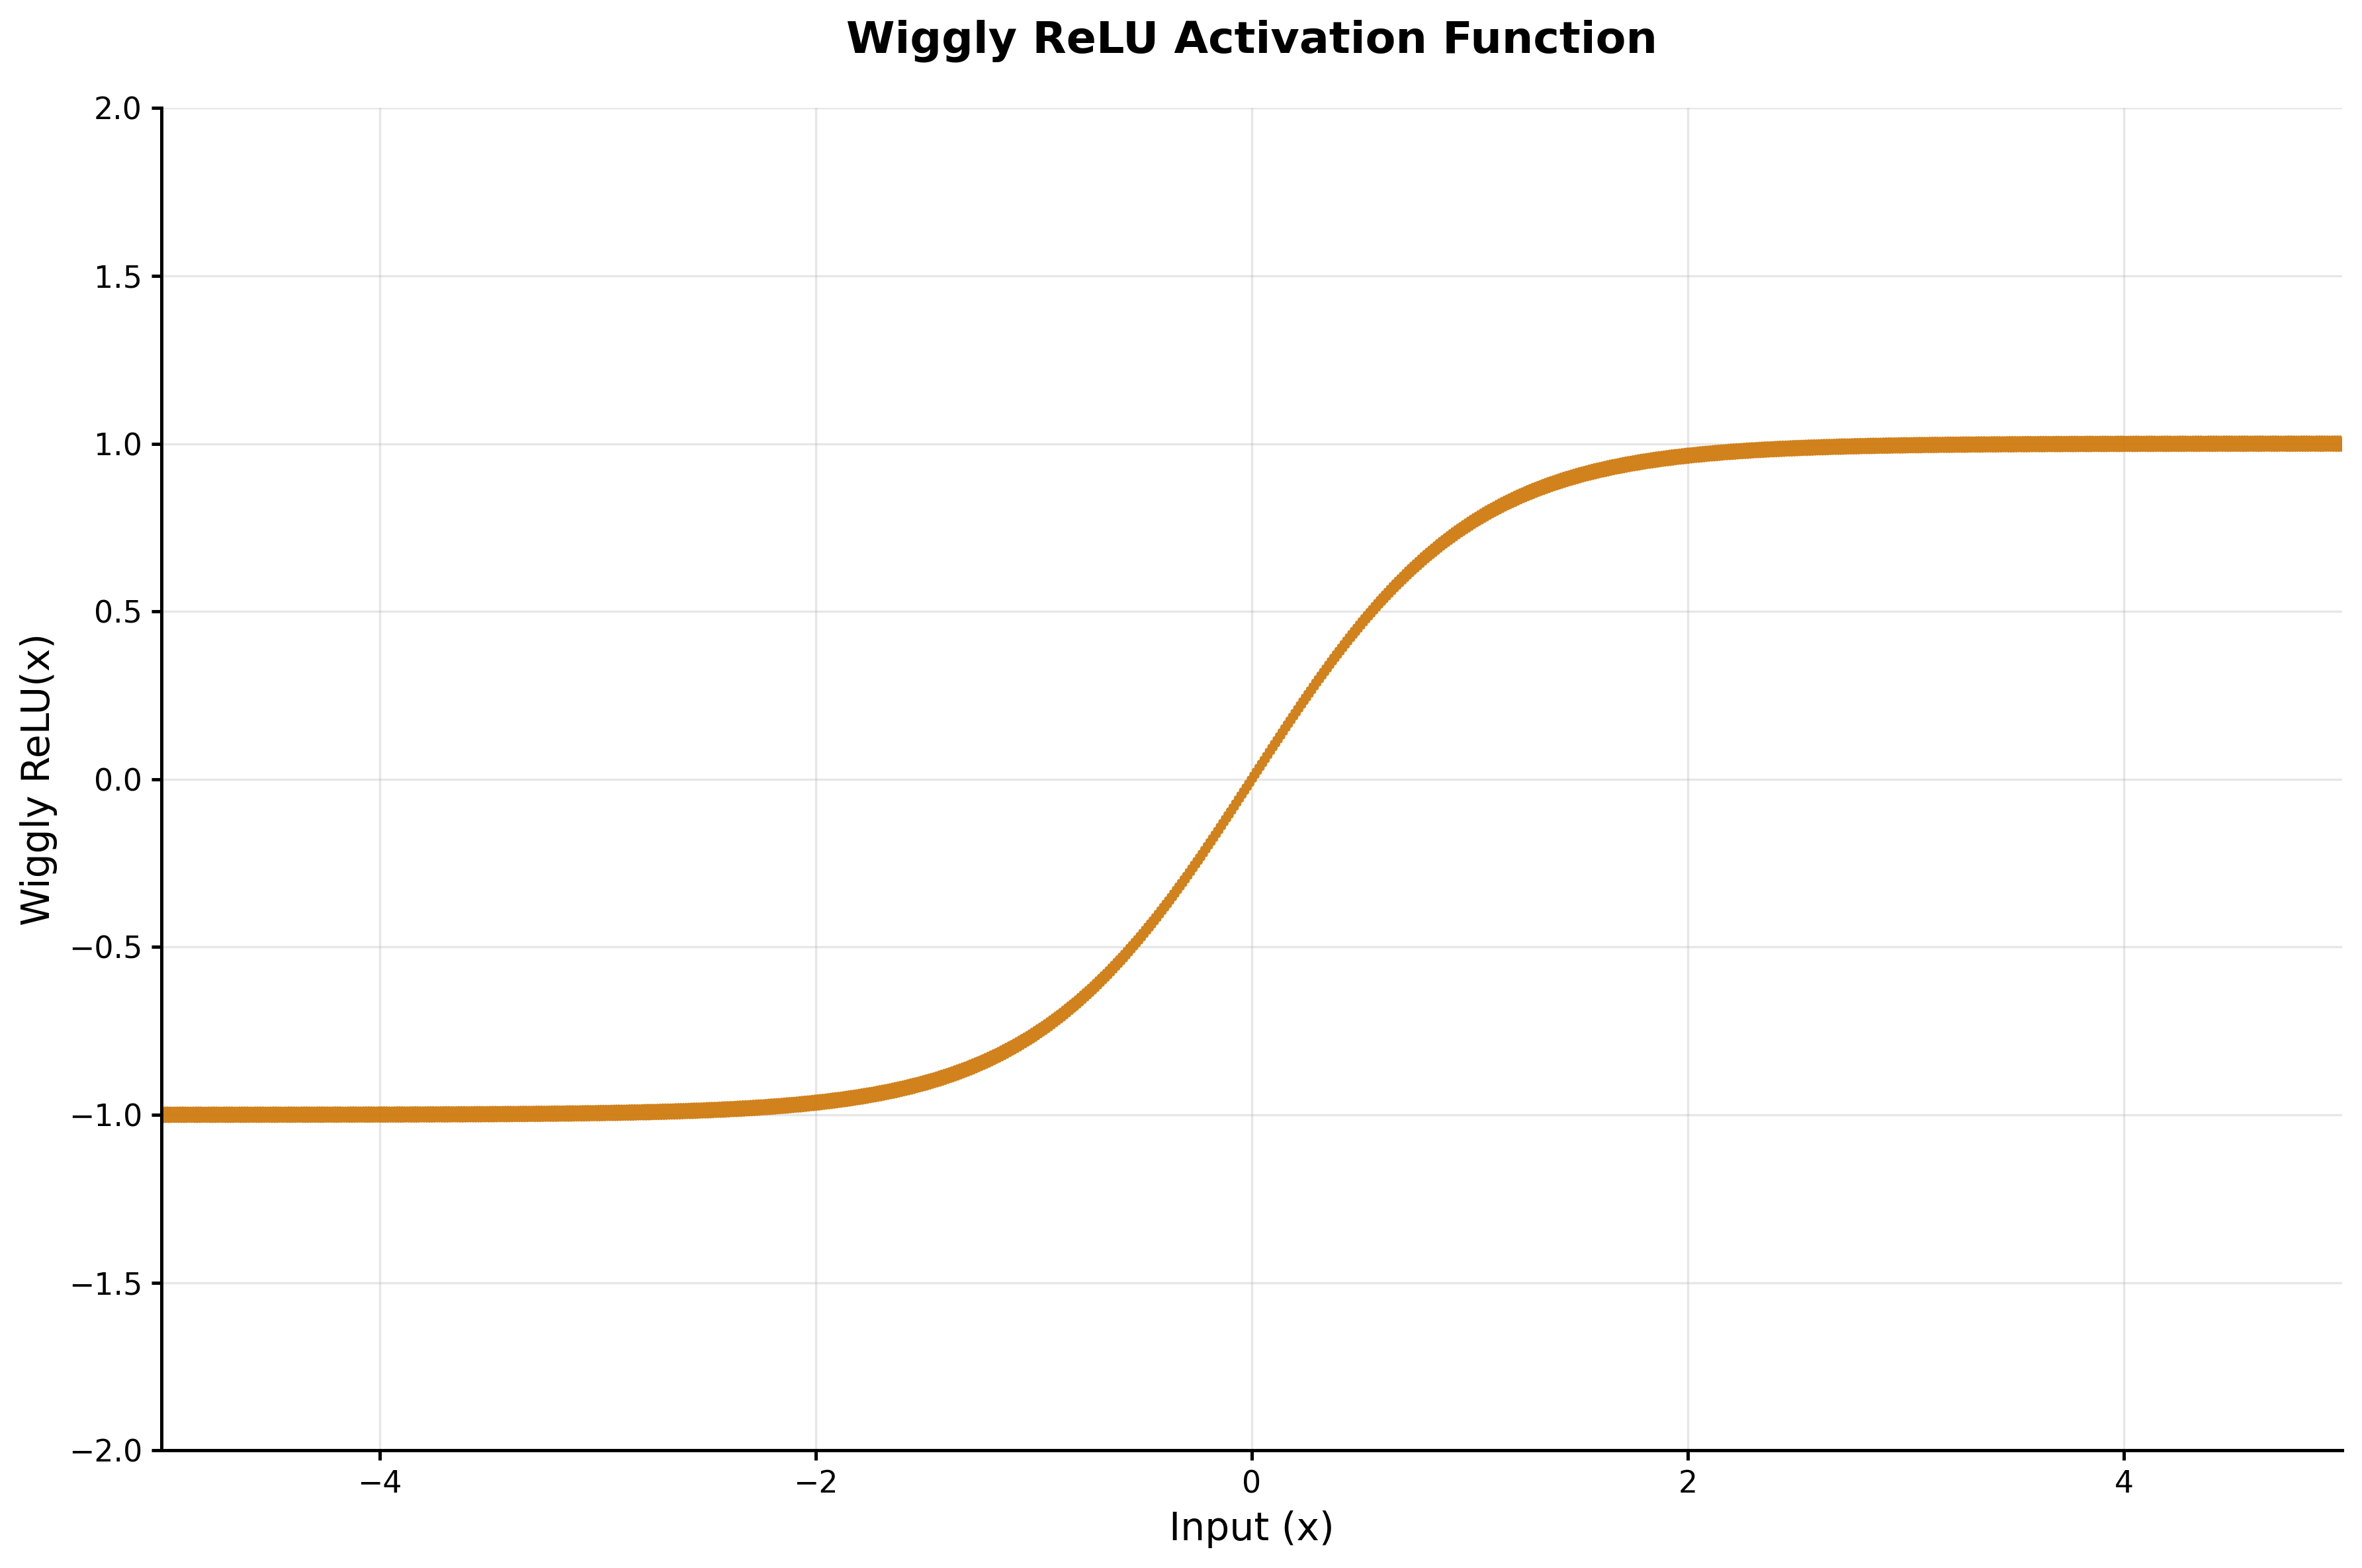

In [84]:
y= wiggly_tanh(x)
plt.figure(figsize=(12, 8), dpi=300)  # High resolution with larger size

# Create the plot with thinner line
plt.plot(x.numpy(), y.numpy(), linewidth=1.2, color='#cc7504', alpha=0.9)

# Professional styling
plt.xlabel('Input (x)', fontsize=14, fontweight='medium')
plt.ylabel('Wiggly ReLU(x)', fontsize=14, fontweight='medium')
plt.title('Wiggly ReLU Activation Function', fontsize=16, fontweight='bold', pad=20)

# Customize tick parameters
plt.tick_params(axis='both', which='major', labelsize=11, width=1.2)
plt.tick_params(axis='both', which='minor', labelsize=9, width=0.8)

# Add grid for better readability
plt.grid(True, alpha=0.3, linewidth=0.8)

# Set axis limits for better framing
plt.xlim(-5, 5)
plt.ylim(-2, 2)

# Add subtle styling touches
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_linewidth(1.2)
plt.gca().spines['bottom'].set_linewidth(1.2)

# Adjust layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()

In [85]:
# Simple CNN Model
class WiggleTanhCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(WiggleTanhCNN, self).__init__()
        # First conv block
        # First conv block
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)  # 32x32 -> 16x16
        
        # Second conv block
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)  # 16x16 -> 8x8
        
        # Third conv block
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)  # 8x8 -> 4x4
        
        # Fully connected layers
        self.fc1 = nn.Linear(256 * 4 * 4, 512 )
        self.fc2 = nn.Linear(512, num_classes)
        
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()


    
    def forward(self, x):
        # First conv block
        x = wiggly_tanh(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.pool1(x)
        
        # Second conv block
        x = wiggly_tanh(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.pool2(x)
        
        # Third conv block
        x = self.relu(self.conv5(x))
        x = self.pool3(x)
        
        # Flatten and fully connected
        x = x.view(x.size(0), -1)
        
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
    
        return x

In [86]:
wiggle_model = WiggleTanhCNN(num_classes=10)  # Make sure num_classes matches what you used when saving

# Load the saved state dictionary
filepath = 'two_tahn_model.pth'
wiggle_model.load_state_dict(torch.load(filepath))
wiggle_model = wiggle_model.to('mps')

# Set the model to evaluation mode (important for inference)
wiggle_model.eval()

print(f"Model loaded from {filepath}")

Model loaded from two_tahn_model.pth


In [80]:
# Simple setup - no complex preprocessing nonsense
wiggle_model = wiggle_model.to('mps')
wiggle_model.eval()
device = 'mps'

# Create attacks
fgsm = torchattacks.FGSM(wiggle_model, eps=50/255)
fgsm.set_mode_targeted_by_label(quiet=True)
pgd = torchattacks.PGD(wiggle_model, eps=8/255, alpha=2/255, steps=40)
pgd.set_mode_targeted_by_label(quiet=True)
cw = torchattacks.CW(wiggle_model, c=1, kappa=0, steps=50)
cw.set_mode_targeted_by_label(quiet=True)
autoattack = torchattacks.AutoAttack(wiggle_model, eps=8/255)


adv_images = []
imgs = []

# Use your normal data loader (with whatever preprocessing your model expects)
for images, labels in testloader:
    # print(images.shape); break
    images, labels = images.to(device)[0:5], labels.to(device)[0:5]
    show_adv_examples(images)
    
    # Generate adversarial examples
    target_labels = torch.zeros_like(labels)
    adv_images = pgd(images, target_labels)
    imgs = images.clone()
    
    # Evaluate
    with torch.no_grad():
        outputs = wiggle_model(adv_images.to(device))
        # print(outputs.device)
        _, predicted = torch.max(outputs, 1)
        print(predicted)
        # print(predicted.device)
        
    success_rate = (predicted == target_labels).float().mean()
    print(f'Attack success rate: {success_rate:.2%}')
    print(len(labels))
    break

show_adv_examples(adv_images)

python(76361) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(76362) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x117d50720>
Traceback (most recent call last):
  File "/Users/zephaniahroe/anaconda3/envs/robustbench-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/Users/zephaniahroe/anaconda3/envs/robustbench-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1627, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/Users/zephaniahroe/anaconda3/envs/robustbench-env/lib/python3.11/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/zephaniahroe/anaconda3/envs/robustbench-env/lib/python3.11/multiprocessing/popen_fork.py", line 4

NameError: name 'show_adv_examples' is not defined

In [29]:
evaluate_model(wiggle_model, testloader)


Overall Test Accuracy: 58.72%

Per-class accuracies:
plane: 72.30%
car: 88.40%
bird: 18.00%
cat: 47.20%
deer: 24.30%
dog: 61.40%
frog: 65.50%
horse: 68.40%
ship: 57.80%
truck: 83.90%


58.72

In [18]:
evaluate_model(model, testloader)


Overall Test Accuracy: 68.53%

Per-class accuracies:
plane: 80.80%
car: 76.80%
bird: 54.50%
cat: 47.60%
deer: 62.50%
dog: 49.20%
frog: 82.10%
horse: 78.50%
ship: 80.80%
truck: 72.50%


68.53

In [ ]:
from autoattack import AutoAttack

# adversary = AutoAttack(wiggle_model, norm='Linf', eps=8/255, version='custom', attacks_to_run=['apgd-ce', 'apgd-dlr'], device='mps')
adversary = AutoAttack(wiggle_model, norm='Linf', eps=8/255, device="mps")

adversary.apgd.n_restarts = 1
for images, labels in testloader:
    print(len(images))
    x_adv = adversary.run_standard_evaluation(images, labels)
    # print(x_adv)
    # break

setting parameters for standard version


python(76383) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(76384) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


128
using standard version including apgd-ce, apgd-t, fab-t, square.
initial accuracy: 89.84%


In [69]:
from autoattack import AutoAttack

# adversary = AutoAttack(wiggle_model, norm='Linf', eps=8/255, version='custom', attacks_to_run=['apgd-ce', 'apgd-dlr'], device='mps')
adversary = AutoAttack(wiggle_model, norm='Linf', eps=8/255, device="mps")

adversary.apgd.n_restarts = 1
for images, labels in testloader:
    print(len(images))
    x_adv = adversary.run_standard_evaluation(images, labels)
    # print(x_adv)
    # break

setting parameters for standard version


python(76276) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(76277) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


128
using standard version including apgd-ce, apgd-t, fab-t, square.
initial accuracy: 89.84%
apgd-ce - 1/1 - 42 out of 115 successfully perturbed
robust accuracy after APGD-CE: 57.03% (total time 6.0 s)
apgd-t - 1/1 - 7 out of 73 successfully perturbed
robust accuracy after APGD-T: 51.56% (total time 48.8 s)
fab-t - 1/1 - 0 out of 66 successfully perturbed
robust accuracy after FAB-T: 51.56% (total time 159.8 s)
square - 1/1 - 64 out of 66 successfully perturbed
robust accuracy after SQUARE: 1.56% (total time 307.4 s)
max Linf perturbation: 0.03137, nan in tensor: 0, max: 1.00000, min: 0.00000
robust accuracy: 1.56%
128
using standard version including apgd-ce, apgd-t, fab-t, square.
initial accuracy: 81.25%
apgd-ce - 1/1 - 32 out of 104 successfully perturbed
robust accuracy after APGD-CE: 56.25% (total time 5.7 s)


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x117d50720>
Traceback (most recent call last):
  File "/Users/zephaniahroe/anaconda3/envs/robustbench-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/Users/zephaniahroe/anaconda3/envs/robustbench-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1627, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/Users/zephaniahroe/anaconda3/envs/robustbench-env/lib/python3.11/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/zephaniahroe/anaconda3/envs/robustbench-env/lib/python3.11/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/zephaniahroe/anaconda3/envs/robustbench-env/lib/python3.11/multiprocessing/connection

KeyboardInterrupt: 

In [119]:
from autoattack import AutoAttack

adversary = AutoAttack(wiggle_model, norm='Linf', eps=8/255, version='custom', attacks_to_run=['apgd-ce', 'apgd-dlr'], device='mps')
adversary.apgd.n_restarts = 1
for images, labels in testloader:
    print(len(images))
    x_adv = adversary.run_standard_evaluation(images, labels)
    # print(x_adv)

128
using custom version including apgd-ce, apgd-dlr.
initial accuracy: 79.69%
apgd-ce - 1/1 - 30 out of 102 successfully perturbed
robust accuracy after APGD-CE: 56.25% (total time 12.5 s)
apgd-dlr - 1/1 - 2 out of 72 successfully perturbed
robust accuracy after APGD-DLR: 54.69% (total time 22.6 s)
max Linf perturbation: 0.03137, nan in tensor: 0, max: 1.00000, min: 0.00000
robust accuracy: 54.69%
128
using custom version including apgd-ce, apgd-dlr.
initial accuracy: 77.34%
apgd-ce - 1/1 - 24 out of 99 successfully perturbed
robust accuracy after APGD-CE: 58.59% (total time 12.3 s)
apgd-dlr - 1/1 - 4 out of 75 successfully perturbed
robust accuracy after APGD-DLR: 55.47% (total time 23.0 s)
max Linf perturbation: 0.03137, nan in tensor: 0, max: 1.00000, min: 0.00000
robust accuracy: 55.47%
128
using custom version including apgd-ce, apgd-dlr.
initial accuracy: 77.34%
apgd-ce - 1/1 - 28 out of 99 successfully perturbed
robust accuracy after APGD-CE: 55.47% (total time 11.3 s)
apgd-dlr

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x10cd50720>
Traceback (most recent call last):
  File "/Users/zephaniahroe/anaconda3/envs/robustbench-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/Users/zephaniahroe/anaconda3/envs/robustbench-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1627, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/Users/zephaniahroe/anaconda3/envs/robustbench-env/lib/python3.11/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/zephaniahroe/anaconda3/envs/robustbench-env/lib/python3.11/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/zephaniahroe/anaconda3/envs/robustbench-env/lib/python3.11/multiprocessing/connection

KeyboardInterrupt: 

In [212]:
from autoattack import AutoAttack

adversary = AutoAttack(wiggle_model, norm='Linf', eps=8/255, version='custom', attacks_to_run=['apgd-ce', 'apgd-dlr'], device='mps')
adversary.apgd.n_restarts = 1
for images, labels in testloader:
    print(len(images))
    x_adv = adversary.run_standard_evaluation(images, labels)
    # print(x_adv)

128
using custom version including apgd-ce, apgd-dlr.
initial accuracy: 86.72%
apgd-ce - 1/1 - 45 out of 111 successfully perturbed
robust accuracy after APGD-CE: 51.56% (total time 19.9 s)
apgd-dlr - 1/1 - 6 out of 66 successfully perturbed
robust accuracy after APGD-DLR: 46.88% (total time 35.3 s)
max Linf perturbation: 0.03137, nan in tensor: 0, max: 1.00000, min: 0.00000
robust accuracy: 46.88%
128
using custom version including apgd-ce, apgd-dlr.
initial accuracy: 81.25%
apgd-ce - 1/1 - 53 out of 104 successfully perturbed
robust accuracy after APGD-CE: 39.84% (total time 16.3 s)
apgd-dlr - 1/1 - 3 out of 51 successfully perturbed
robust accuracy after APGD-DLR: 37.50% (total time 28.9 s)
max Linf perturbation: 0.03137, nan in tensor: 0, max: 1.00000, min: 0.00000
robust accuracy: 37.50%
128
using custom version including apgd-ce, apgd-dlr.
initial accuracy: 84.38%
apgd-ce - 1/1 - 57 out of 108 successfully perturbed
robust accuracy after APGD-CE: 39.84% (total time 16.8 s)
apgd-d

KeyboardInterrupt: 

In [206]:
adversary = AutoAttack(model, norm='Linf', eps=8/255, version='custom', attacks_to_run=['apgd-ce', 'apgd-dlr'], device='mps')
adversary.apgd.n_restarts = 1
for images, labels in testloader:
    print(len(images))
    x_adv = adversary.run_standard_evaluation(images, labels)
    # print(x_adv)

128
using custom version including apgd-ce, apgd-dlr.
initial accuracy: 90.62%
apgd-ce - 1/1 - 116 out of 116 successfully perturbed
robust accuracy after APGD-CE: 0.00% (total time 13.0 s)
max Linf perturbation: 0.03137, nan in tensor: 0, max: 1.00000, min: 0.00000
robust accuracy: 0.00%
128
using custom version including apgd-ce, apgd-dlr.
initial accuracy: 83.59%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x11de50720>
Traceback (most recent call last):
  File "/Users/zephaniahroe/anaconda3/envs/robustbench-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/Users/zephaniahroe/anaconda3/envs/robustbench-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1627, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/Users/zephaniahroe/anaconda3/envs/robustbench-env/lib/python3.11/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/zephaniahroe/anaconda3/envs/robustbench-env/lib/python3.11/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/zephaniahroe/anaconda3/envs/robustbench-env/lib/python3.11/multiprocessing/connection

KeyboardInterrupt: 

In [24]:
def show_adv_examples(adv_images):
    # Show first 4 examples (or less if batch is smaller)
    num_to_show = min(4, adv_images.shape[0])
    
    fig, axes = plt.subplots(1, num_to_show, figsize=(12, 3))
    if num_to_show == 1:
        axes = [axes]
    
    for i in range(num_to_show):
        # Convert from (C, H, W) to (H, W, C) and move to CPU
        img = adv_images[i].permute(1, 2, 0).cpu().detach()
        
        # Clip values to [0, 1] range for display
        img = torch.clamp(img, 0, 1)
        
        axes[i].imshow(img)
        axes[i].set_title(f'Adv Example {i+1}')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

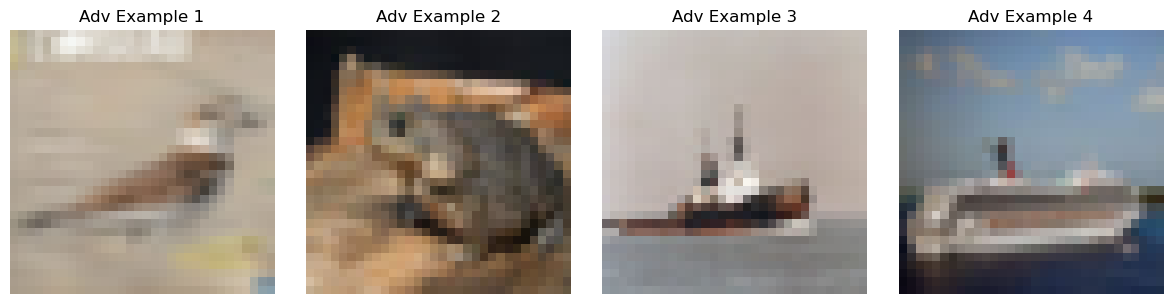

tensor([0, 0, 0, 0, 0], device='mps:0')
Attack success rate: 100.00%
5


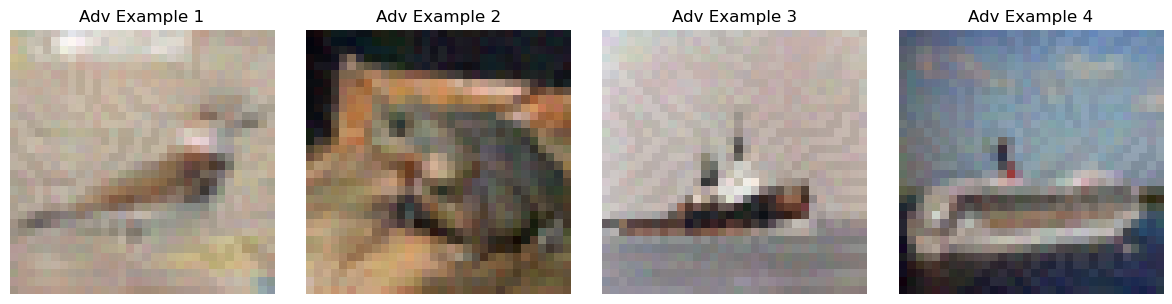

In [20]:
# Simple setup - no complex preprocessing nonsense
model = model.to('mps')
model.eval()
device = 'mps'

# Create attacks
fgsm = torchattacks.FGSM(model, eps=50/255)
fgsm.set_mode_targeted_by_label(quiet=True)
pgd = torchattacks.PGD(model, eps=8/255, alpha=2/255, steps=40)
pgd.set_mode_targeted_by_label(quiet=True)
cw = torchattacks.CW(model, c=1, kappa=0, steps=50)
cw.set_mode_targeted_by_label(quiet=True)
autoattack = torchattacks.AutoAttack(model, eps=8/255)


adv_images = []
imgs = []

# Use your normal data loader (with whatever preprocessing your model expects)
for images, labels in testloader:
    # print(images.shape); break
    images, labels = images.to(device)[70:75], labels.to(device)[70:75]
    show_adv_examples(images)
    
    # Generate adversarial examples
    target_labels = torch.zeros_like(labels)
    adv_images = pgd(images, target_labels)
    imgs = images.clone()
    
    # Evaluate
    with torch.no_grad():
        outputs = model(adv_images.to(device))
        # print(outputs.device)
        _, predicted = torch.max(outputs, 1)
        print(predicted)
        # print(predicted.device)
        
    success_rate = (predicted == target_labels).float().mean()
    print(f'Attack success rate: {success_rate:.2%}')
    print(len(labels))
    break

show_adv_examples(adv_images)

In [ ]:
# Simple setup - no complex preprocessing nonsense
model = model.to('mps')
model.eval()
device = 'mps'

# Create attacks
fgsm = torchattacks.FGSM(model, eps=50/255)
fgsm.set_mode_targeted_by_label(quiet=True)
pgd = torchattacks.PGD(model, eps=8/255, alpha=2/255, steps=100)
pgd.set_mode_targeted_by_label(quiet=True)
cw = torchattacks.CW(model, c=1.5, kappa=0, steps=200)
cw.set_mode_targeted_by_label(quiet=True)
autoattack = torchattacks.AutoAttack(model, eps=8/255)